# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 04 - Дерево решений
## Date: 2020-09-03

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

## ООП Реализация

In [3]:
class Node:

    INSTANCE = 0
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        Node.INSTANCE += 1

    def __del__(self):
        Node.INSTANCE -= 1

In [4]:
class Leaf:
    INSTANCE = 0

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        Leaf.INSTANCE += 1
        self.prediction = self.predict()

    def __del__(self):
        Leaf.INSTANCE -= 1

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [5]:
class DesisionTree:
    def __init__(self, criteria='gini', max_leaf=100):
        self.criteria = criteria
        self.max_leaf = max_leaf
        self.Node = None

    def gini(self, labels: np.array) -> float:
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    def entropia(self, labels: np.array) -> float:
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p)

        return impurity

    def quality(self, left_labels, right_labels, current_informations):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        if self.criteria == 'entropia':
            return current_informations - p * self.entropia(left_labels) - (1 - p) * self.entropia(right_labels)
        else:
            return current_informations - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        if self.criteria == 'entropia':
            current_informations = self.entropia(labels)
        else:
            current_informations = self.gini(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_informations)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
        
        # Если достигли ограничения по количеству листьев - прекращаем рекурсию
        if Leaf.INSTANCE >= self.max_leaf:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
        
    def predict(self, data):
        """
        Выполнить предсказание
        """
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.Node)
            classes.append(prediction)
        return np.array(classes)

    def fit(self, train_data, train_labels):
        self.Node = self.build_tree(train_data, train_labels)

In [6]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

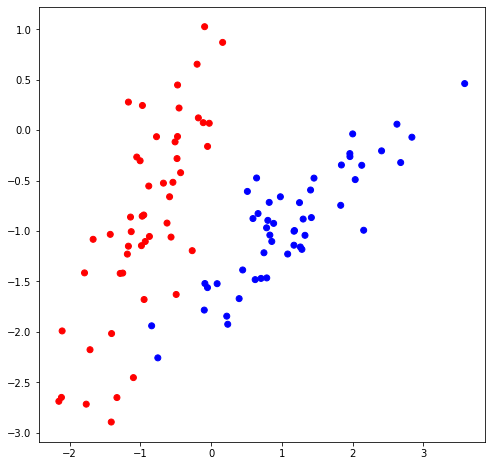

In [7]:
# сгенерируем и разобъем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 27)
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

### Построение прогноза

In [8]:
dTree = DesisionTree(criteria='gini')
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)

In [9]:
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.6f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.6f}')

 Train data
 Accurance metric: 97.142857
 Test data
 Accurance metric: 86.666667


## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [10]:
dTree = DesisionTree(criteria='gini', max_leaf=2)
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.10f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.10f}')

 Train data
 Accurance metric: 97.1428571429
 Test data
 Accurance metric: 86.6666666667


In [11]:
dTree = DesisionTree(criteria='gini', max_leaf=4)
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.10f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.10f}')

 Train data
 Accurance metric: 97.1428571429
 Test data
 Accurance metric: 86.6666666667


In [12]:
dTree = DesisionTree(criteria='gini', max_leaf=10)
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.10f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.10f}')

 Train data
 Accurance metric: 97.1428571429
 Test data
 Accurance metric: 86.6666666667


In [13]:
dTree = DesisionTree(criteria='gini', max_leaf=100)
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.10f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.10f}')

 Train data
 Accurance metric: 97.1428571429
 Test data
 Accurance metric: 86.6666666667


## 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [14]:
dTree_e = DesisionTree(criteria='entropia')
dTree_e.fit(train_data, train_labels)
train_answers_e = dTree_e.predict(train_data)
test_answers_e = dTree_e.predict(test_data)

In [15]:
dTree = DesisionTree(criteria='gini')
dTree.fit(train_data, train_labels)
train_answers = dTree.predict(train_data)
test_answers = dTree.predict(test_data)

In [16]:
print('gini')
print('='*8)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers):.6f}')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers):.6f}')

print('\n\nEntropia')
print("="*8)
print(f' Train data\n Accurance metric: {accuracy_metric(train_labels, train_answers_e):.6f}\n')
print(f' Test data\n Accurance metric: {accuracy_metric(test_labels, test_answers_e):.6f}')


gini
 Train data
 Accurance metric: 97.142857
 Test data
 Accurance metric: 86.666667


Entropia
 Train data
 Accurance metric: 97.142857

 Test data
 Accurance metric: 86.666667


### Критерий джини и энтропии дают схожие значения

## 3*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [17]:
class RegressionLeaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()        
        
    def predict(self):              
        prediction = np.mean(self.labels)        
        return prediction

In [18]:
class RegressionTree:
    def __init__(self, max_leaf=100):
        self.max_leaf = max_leaf
        self.Node = None
    
    def variance(self, labels: np.array) -> float:
        return np.mean((labels - np.mean(labels))**2) 

    def quality(self, left_labels, right_labels, current_informations):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_informations - p * self.variance(left_labels) - (1 - p) * self.variance(right_labels)

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_informations = self.variance(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_informations)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return RegressionLeaf(data, labels)
        
        # Если достигли ограничения по количеству листьев - прекращаем рекурсию
        if Leaf.INSTANCE >= self.max_leaf:
            return RegressoinLeaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, RegressionLeaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
        
    def predict(self, data):
        """
        Выполнить предсказание
        """
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.Node)
            classes.append(prediction)
        return np.array(classes)

    def fit(self, train_data, train_labels):
        self.Node = self.build_tree(train_data, train_labels)

In [20]:
X, y = datasets.make_regression(n_samples=1000, n_features=2, random_state=42)

# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [21]:
def R2(act, pred):
    S_total = ((act - np.mean(act))**2).sum()
    S_res = ((act - pred)**2).sum()
    return 1 - S_res / S_total

In [22]:
tree = RegressionTree()
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

In [23]:
# R2 на обучающей выборке
R2_train = R2(y_train, y_pred_train)
# R2 на тестовой выборке
R2_test = R2(y_test, y_pred_test)
print(f'R2 train: {R2_train:.4f}')
print(f'R2 test: {R2_test:.4f}')

R2 train: 0.9963
R2 test: 0.9856
